In [5]:
!python -m pip install -q --upgrade pip

In [6]:
!pip install -q psutil

In [7]:
!pip install -q findspark

In [8]:
!pip install -q pyspark

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
import findspark
findspark.init("C:\spark\spark-3.5.0-bin-hadoop3")

In [11]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

In [12]:
spark = SparkSession.builder\
    .master('local')\
        .appName('PysparkWordCountApp')\
            .getOrCreate()

sc = spark.sparkContext 

rdd = sc.textFile('./leipzig124MB.txt')

print('appName : ', sc.appName)
print('version : ', sc.version)
print('sparkUser : ', sc.sparkUser())

appName :  PysparkWordCountApp
version :  3.5.0
sparkUser :  90530


In [13]:
sc

<SparkContext master=local appName=PysparkWordCountApp>

In [14]:
contractions = {
    r"'m": " am",
    r"’m": ' am',
    r"'s": ' is',
    r"’s": ' is',
    r"isn't": "is not",
    r"Isn't": "Is not",
    r"'re": " are",
    r"’re": " are",
    r"aren't": "are not",
    r"Aren't": "Are not",
    r"'ve": " have",
    r"’ve": " have",
    r"haven't": "have not",
    r"Haven't": "Have not",
    r"'d": " would",
    r"’d": " would",
    r"wouldn't": "would not",
    r"Wouldn't": "Would not",
    r"don't": "do not",
    r"doesn't": "does not",
    r"didn't": "did not",
    r"Don't": "Do not",
    r"Doesn't": "Does not",
    r"Didn't": "Did not",
    r"can't": "cannot",
    r"Can't": "Cannot",
    r"won't": "will not",
    r"Won't": "Will not",
    r"shan't": "shall not",
    r"Shan't": "Shall not",
    r"'ll": " will",
    r"shouldn't": "should not",
    r"Shouldn't": "Should not",
    r"could've": "could have",
    r"Could've": "Could have",
    r"couldn't": "could not",
    r"Couldn't": "Could not",
    r"might've": "might have",
    r"Might've": "Might have",
    r"mustn't": "must not",
    r"Mustn't": "Must not",
}

def remove_contractions(text):
  for pattern, replacement in contractions.items():
    text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
  return text

def clean_data(x):

  if len(x) > 1:
    punc='!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~-0123456789'
    lowercased_str = x.lower()
    lowercased_str = re.sub(' +', ' ', lowercased_str)
    for ch in punc: 
      lowercased_str = lowercased_str.replace(ch, '')
    return lowercased_str


In [15]:
rdd_reCont = rdd.map(remove_contractions)

cleaned_rdd = rdd_reCont.map(clean_data)

cleaned_rdd.count()

1000000

In [16]:
cleaned_rdd.take(10)

['a rebel statement sent to lisbon from jamba said  government soldiers and  guerrillas were killed in the fighting that ended jan  it said the rebel forces sill held mavinga',
 'authorities last week issued a vacate order for a club in manhattan and closed another in the bronx',
 'at the first pan am bankruptcy hearing for example at least five airlines were represented',
 'mr neigum pokerfaced during the difficult task manages a second showing',
 'this combined with the container division talks suggests the group is bankers might be considering an orderly disposal of all assets',
 'she told the post in an interview published sunday that some of the money may have become mingled into improvements on her home that included a swimming pool a  widescreen television and renovations to her basement',
 'according to a study by the marshall institute the average nasa employee is age in  was  now most of its senior and middlemanagers will be eligible to retire in five years',
 'preston tisch 

In [17]:
words = cleaned_rdd.flatMap(lambda line : line.split(' '))
words.take(10)

['a',
 'rebel',
 'statement',
 'sent',
 'to',
 'lisbon',
 'from',
 'jamba',
 'said',
 '']

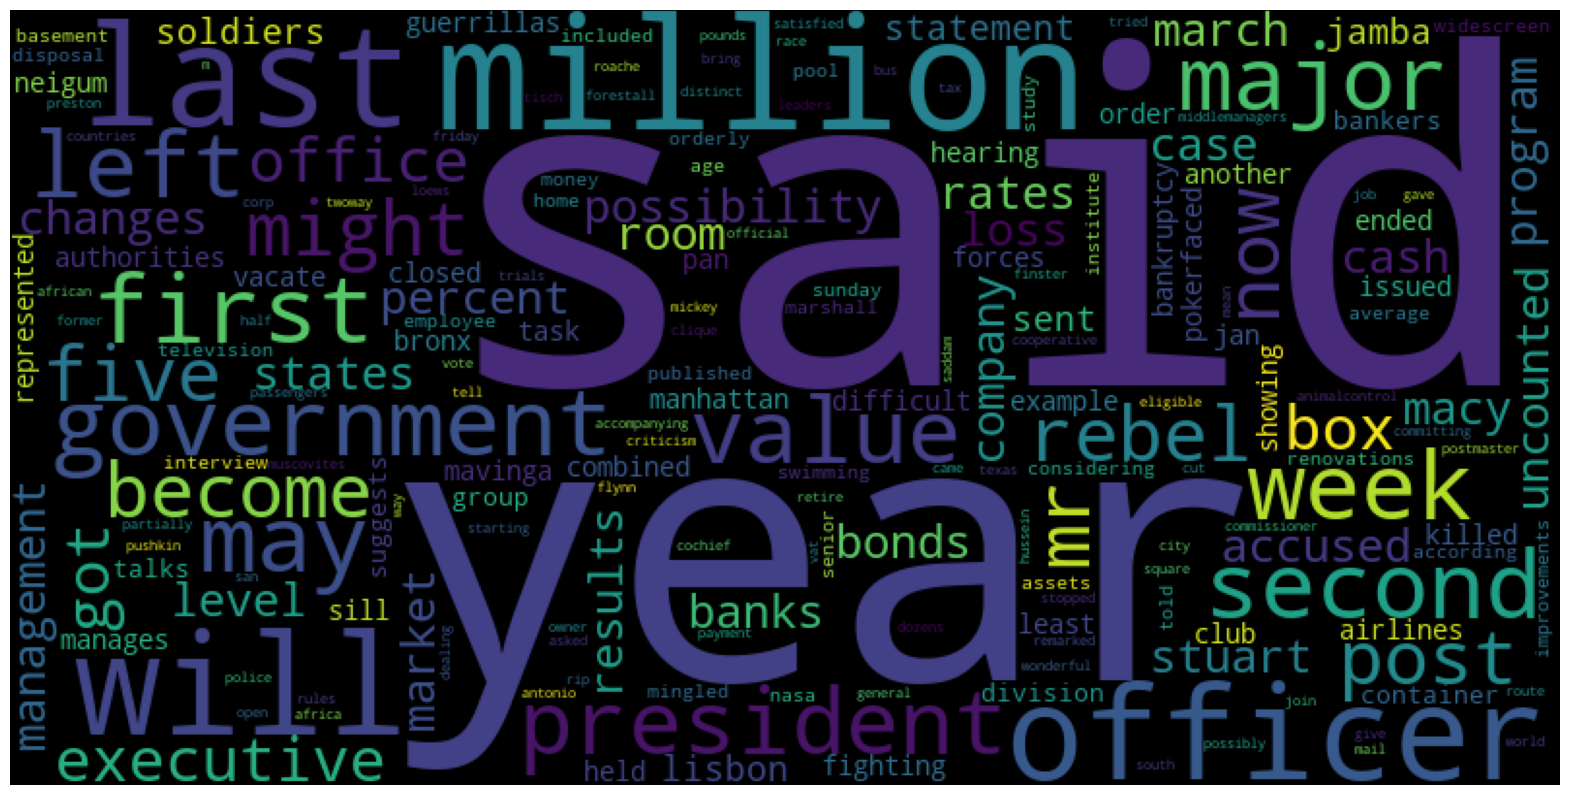

In [27]:
plt.subplots(figsize=(20, 15))
word_cloud = WordCloud(background_color='black', width=800, height=400).generate(' '.join(words.collect()[:1000]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [19]:
uniqueWords = words.map(lambda word : (word, 1))
uniqueWords.take(10)

[('a', 1),
 ('rebel', 1),
 ('statement', 1),
 ('sent', 1),
 ('to', 1),
 ('lisbon', 1),
 ('from', 1),
 ('jamba', 1),
 ('said', 1),
 ('', 1)]

In [20]:
wordCounts = uniqueWords.reduceByKey(lambda x, y : x + y)
wordCounts.take(10)

[('statement', 4977),
 ('sent', 3644),
 ('jamba', 7),
 ('', 473818),
 ('soldiers', 3388),
 ('guerrillas', 1947),
 ('killed', 6687),
 ('in', 473567),
 ('authorities', 5082),
 ('last', 36104)]

In [21]:
wordCounts.count() 

207014

In [22]:
sortedWordCounts = sorted(wordCounts.collect(), key=lambda x : x[1], reverse=True)
sortedWordCounts = spark.sparkContext.parallelize(sortedWordCounts)
sortedWordCounts.take(10)

[('the', 1370263),
 ('of', 595835),
 ('to', 566298),
 ('a', 507828),
 ('', 473818),
 ('in', 473567),
 ('and', 448469),
 ('is', 400135),
 ('said', 215897),
 ('for', 214759)]

In [23]:
firstTenWords = sortedWordCounts.take(10)   

with open("firstTenWord.txt", 'w') as f:
    for word ,count in firstTenWords:
        f.write(f'{word}\t{count}\n')

In [24]:
print('Word \t\t\t\t Count')
print('-----------------------------------------------')

with open('firstTenWord.txt' , 'r') as f:
    lines = f.readlines()
    for line in lines:
        word, count = line.split('\t')
        if len(word) <= 3:
            print(f"-{word}   \t\t\t|\t {count}")
        elif len(word) > 11:
            print(f"-{word}   \t|\t {count}")
        else:
            print(f"-{word}   \t\t|\t {count}")

Word 				 Count
-----------------------------------------------
-the   			|	 1370263

-of   			|	 595835

-to   			|	 566298

-a   			|	 507828

-   			|	 473818

-in   			|	 473567

-and   			|	 448469

-is   			|	 400135

-said   		|	 215897

-for   			|	 214759



In [ ]:
sc.stop()